# 7. Data Augmentation, Retraining, and Sharing our Work

In this final notebook, we'll use the insights gained from our analysis to improve our model. We will identify challenging samples from the training set—those that were misclassified, are highly unique, or had low prediction confidence. We will then apply targeted **data augmentation** to these samples and fine-tune our LeNet model on this enriched dataset.

**Key concepts covered:**
*   Identifying problematic samples for augmentation
*   Defining effective data augmentation strategies for MNIST
*   Creating a combined dataset of original and augmented data
*   Fine-tuning a pre-trained model
*   Comparing performance before and after fine-tuning
*   Saving our work on the local hard drive
*   [Pushing our curated dataset to HuggingFace Hub](https://docs.voxel51.com/integrations/huggingface.html#pushing-datasets-to-the-hub) with FiftyOne format

![](https://github.com/andandandand/fiftyone/blob/develop/docs/source/getting_started_experiences/Classification/assets/now_correct_view.webp?raw=True)



## Setup
Let's begin by setting up our environment, including all necessary imports and helper functions.

In [1]:
import os
import random
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, ConcatDataset
from torch.optim import Adam
from torch.utils.data import Dataset


import fiftyone as fo
from fiftyone import ViewField as F
from fiftyone.utils.huggingface import push_to_hub
from fiftyone.utils.huggingface import load_from_hub


import albumentations as A

import getpass
from huggingface_hub import login


# Redefine model and dataset classes
class ModernLeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(ModernLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.pool(Fun.relu(self.conv1(x)))
        x = self.pool(Fun.relu(self.conv2(x)))
        x = Fun.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = Fun.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def create_deterministic_training_dataloader(dataset, batch_size, shuffle=True, **kwargs):
    generator = torch.Generator().manual_seed(51)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, generator=generator if shuffle else None, **kwargs)

def set_seeds(seed=51):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

## Identifying Samples for Augmentation

First, we need to get our model's predictions on the training set to identify which samples it misclassified. We'll need to run inference on the training set, similar to how we did for the test set.

In [2]:
# Load datasets and model
device = "cuda" if torch.cuda.is_available() else "cpu"
train_dataset = fo.load_dataset("mnist-training-set")
test_dataset = fo.load_dataset("mnist-test-set")
model_save_path = Path(os.getcwd()) / 'best_lenet.pth'
loaded_model = ModernLeNet5().to(device)
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))

# Recreate transforms and dataloaders
mean_intensity, std_intensity = 0.1307, 0.3081 # Pre-computed
image_transforms = transforms.Compose([
    transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((mean_intensity,), (std_intensity,))
])
dataset_classes = sorted(train_dataset.distinct("ground_truth.label"))
label_map = {label: i for i, label in enumerate(dataset_classes)}

class CustomTorchImageDataset(Dataset):
    def __init__(self, fo_dset, xforms, l_map):
        self.fo_dset, self.xforms, self.l_map = fo_dset, xforms, l_map
        self.img_paths = self.fo_dset.values("filepath")
        self.labels = self.fo_dset.values("ground_truth.label")
    def __len__(self): return len(self.img_paths)
    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('L')
        label = self.l_map[self.labels[idx]]
        return self.xforms(img), torch.tensor(label, dtype=torch.long)

torch_train_set = CustomTorchImageDataset(train_dataset, image_transforms, label_map)
train_inference_loader = torch.utils.data.DataLoader(torch_train_set, batch_size=64, shuffle=False)

# Add predictions to training set if they don't exist
if "lenet_train_classification" not in train_dataset.get_field_schema():
    train_preds, train_logits = [], []
    with torch.inference_mode():
        for imgs, _ in tqdm(train_inference_loader, desc="Getting train preds"):
            logits = loaded_model(imgs.to(device))
            train_logits.append(logits.cpu().numpy())
            train_preds.extend(torch.max(logits, 1)[1].cpu().numpy())
    train_logits = np.concatenate(train_logits)
    
    classifications = []
    for i in range(len(train_dataset)):
        pred_idx = train_preds[i]
        logits = train_logits[i]
        conf = float(Fun.softmax(torch.tensor(logits), dim=0)[pred_idx])
        classifications.append(fo.Classification(label=dataset_classes[pred_idx], confidence=conf, logits=logits.tolist()))
    train_dataset.set_values("lenet_train_classification", classifications)
    train_dataset.save()

# Create view of misclassified training samples
mislabeled_train_images_view = train_dataset.match(F("lenet_train_classification.label") != F("ground_truth.label"))
print(f"Found {len(mislabeled_train_images_view)} misclassified training samples.")

Getting train preds: 100%|██████████| 797/797 [00:16<00:00, 47.09it/s]


Found 498 misclassified training samples.


## Defining Augmentations

Effective augmentation for MNIST involves creating realistic variations that a model might encounter. We'll use small geometric transformations (rotation, translation, scaling) and elastic deformations to simulate natural handwriting styles. We will use the `albumentations` library for this.

In [3]:
set_seeds(51)
mnist_augmentations = A.Compose([
    A.Affine(
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        scale=(0.9, 1.1),
        rotate=(-10, 10),
        p=0.8
    ),
    A.ElasticTransform(
        alpha=20, sigma=5, border_mode=cv2.BORDER_CONSTANT, p=0.6
    ),
    A.GridDistortion(num_steps=3, distort_limit=0.1, p=0.3),
])

### Creating an Augmented Dataset

We'll define a new PyTorch `Dataset` class that takes our misclassified samples and applies these augmentations on the fly. For each misclassified sample, it will generate multiple augmented versions.

In [4]:
class AugmentedMNISTDataset(Dataset):
    def __init__(self, fiftyone_view, label_map, base_transforms, augmentations, augment_factor=5):
        self.image_paths = fiftyone_view.values("filepath")
        self.str_labels = fiftyone_view.values("ground_truth.label")
        self.label_map = label_map
        self.base_transforms = base_transforms
        self.augmentations = augmentations
        self.augment_factor = augment_factor

    def __len__(self):
        return len(self.image_paths) * self.augment_factor

    def __getitem__(self, idx):
        base_idx = idx // self.augment_factor
        image = Image.open(self.image_paths[base_idx]).convert('L')
        image_np = np.array(image, dtype=np.uint8)
        augmented = self.augmentations(image=image_np)['image']
        image = Image.fromarray(augmented).convert("L")
        if self.base_transforms: image = self.base_transforms(image)
        label_idx = self.label_map.get(self.str_labels[base_idx], -1)
        return image, torch.tensor(label_idx, dtype=torch.long)

In [5]:
torch_augmented_dataset = AugmentedMNISTDataset(
    mislabeled_train_images_view,
    label_map=label_map,
    base_transforms=image_transforms,
    augmentations=mnist_augmentations,
    augment_factor=10
)

# Combine original training set with the new augmented samples
combined_dataset = ConcatDataset([torch_train_set, torch_augmented_dataset])
print(f"Original training set size: {len(torch_train_set)}")
print(f"Augmented samples added: {len(torch_augmented_dataset)}")
print(f"Combined dataset size: {len(combined_dataset)}")

# Create a new DataLoader for fine-tuning
combined_train_loader = create_deterministic_training_dataloader(
    combined_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count()
)

Original training set size: 51000
Augmented samples added: 4980
Combined dataset size: 55980


## Fine-Tuning the Model

We'll now fine-tune our model. We start with the best weights from our initial training and train for a few more epochs on the combined dataset. We use a **lower learning rate** for fine-tuning to make small, careful adjustments to the already-learned weights.

In [6]:
set_seeds(51)
# Load the best model to start fine-tuning
retrain_model = ModernLeNet5().to(device)
retrain_model.load_state_dict(torch.load(model_save_path, map_location=device))

# Use a 10x smaller learning rate for fine-tuning
retrain_optimizer = Adam(retrain_model.parameters(), lr=0.0001)
ce_loss = nn.CrossEntropyLoss()

# Reload the validation loader
val_dataset = fo.load_dataset("mnist-validation-set")
torch_val_set = CustomTorchImageDataset(val_dataset, image_transforms, label_map)
val_loader = torch.utils.data.DataLoader(torch_val_set, batch_size=64)

# Initialize lists to track losses
train_losses = []
val_losses = []

# Training loop
retrain_epochs = 10
best_retrain_val_loss = float('inf')
retrain_model_save_path = Path(os.getcwd()) / 'retrained_lenet.pth'

for epoch in range(retrain_epochs):
    retrain_model.train()
    epoch_train_losses = []
    
    # Training phase
    for images, labels in tqdm(combined_train_loader, desc=f"Retraining Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        retrain_optimizer.zero_grad()
        logits = retrain_model(images)
        loss = ce_loss(logits, labels)
        loss.backward()
        retrain_optimizer.step()
        epoch_train_losses.append(loss.item())

    # Validation phase
    retrain_model.eval()
    epoch_val_losses = []
    with torch.inference_mode():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            logits = retrain_model(images)
            epoch_val_losses.append(ce_loss(logits, labels).item())
    
    # Calculate average losses for the epoch
    avg_train_loss = np.mean(epoch_train_losses)
    avg_val_loss = np.mean(epoch_val_losses)
    
    # Store losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_retrain_val_loss:
        best_retrain_val_loss = avg_val_loss
        torch.save(retrain_model.state_dict(), retrain_model_save_path)
        print("Saved improved retrained model")

Retraining Epoch 1:   0%|          | 0/875 [00:00<?, ?it/s]

Retraining Epoch 1: 100%|██████████| 875/875 [00:12<00:00, 71.89it/s] 


Epoch 1 - Training Loss: 0.1856, Validation Loss: 0.0411
Saved improved retrained model


Retraining Epoch 2: 100%|██████████| 875/875 [00:12<00:00, 69.86it/s] 


Epoch 2 - Training Loss: 0.1489, Validation Loss: 0.0398
Saved improved retrained model


Retraining Epoch 3: 100%|██████████| 875/875 [00:12<00:00, 70.39it/s] 


Epoch 3 - Training Loss: 0.1345, Validation Loss: 0.0398
Saved improved retrained model


Retraining Epoch 4: 100%|██████████| 875/875 [00:12<00:00, 69.52it/s] 


Epoch 4 - Training Loss: 0.1231, Validation Loss: 0.0409


Retraining Epoch 5: 100%|██████████| 875/875 [00:12<00:00, 72.80it/s] 


Epoch 5 - Training Loss: 0.1165, Validation Loss: 0.0412


Retraining Epoch 6: 100%|██████████| 875/875 [00:12<00:00, 71.00it/s] 


Epoch 6 - Training Loss: 0.1083, Validation Loss: 0.0415


Retraining Epoch 7: 100%|██████████| 875/875 [00:16<00:00, 53.31it/s] 


Epoch 7 - Training Loss: 0.1030, Validation Loss: 0.0417


Retraining Epoch 8: 100%|██████████| 875/875 [00:12<00:00, 69.78it/s] 


Epoch 8 - Training Loss: 0.1001, Validation Loss: 0.0409


Retraining Epoch 9: 100%|██████████| 875/875 [00:12<00:00, 68.02it/s] 


Epoch 9 - Training Loss: 0.0954, Validation Loss: 0.0419


Retraining Epoch 10: 100%|██████████| 875/875 [00:12<00:00, 70.30it/s] 


Epoch 10 - Training Loss: 0.0931, Validation Loss: 0.0420


## Plotting training vs validation losses

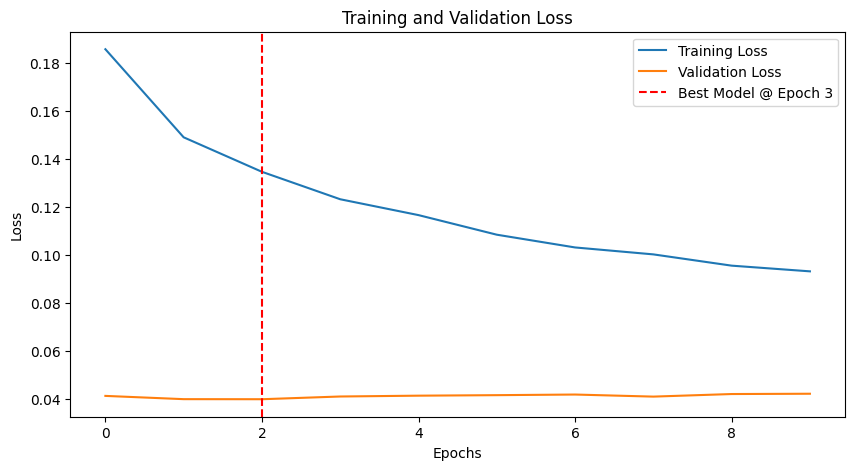

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
best_epoch = np.argmin(val_losses) + 1
plt.axvline(x=best_epoch-1, color='r', linestyle='--', label=f'Best Model @ Epoch {best_epoch}')
plt.legend()
plt.show()

## Final Evaluation

Finally, let's evaluate our newly fine-tuned model on the test set and compare its performance to the original model.

In [8]:
# Load the best retrained model
final_model = ModernLeNet5().to(device)
final_model.load_state_dict(torch.load(retrain_model_save_path, map_location=device))
final_model.eval()

# Create test loader
torch_test_set = CustomTorchImageDataset(test_dataset, image_transforms, label_map)
test_loader = torch.utils.data.DataLoader(torch_test_set, batch_size=64)

# Run inference with the retrained model
retrained_predictions, retrained_logits = [], []
with torch.inference_mode():
    for images, _ in tqdm(test_loader, desc="Evaluating retrained model"):
        logits = final_model(images.to(device))
        retrained_logits.append(logits.cpu().numpy())
        retrained_predictions.extend(torch.max(logits.data, 1)[1].cpu().numpy())

retrained_logits = np.concatenate(retrained_logits, axis=0)

# Store retrained predictions in FiftyOne
for i, sample in enumerate(test_dataset):
    pred_idx = retrained_predictions[i]
    logits = retrained_logits[i]
    conf = float(Fun.softmax(torch.tensor(logits), dim=0)[pred_idx])
    sample["retrained_lenet_classification"] = fo.Classification(
        label=dataset_classes[pred_idx], confidence=conf, logits=logits.tolist()
    )
    sample.save()

print("Retrained predictions stored.")

Evaluating retrained model:  13%|█▎        | 20/157 [00:00<00:03, 41.71it/s]

Evaluating retrained model: 100%|██████████| 157/157 [00:03<00:00, 40.86it/s]


Retrained predictions stored.


In [9]:
# Evaluate original and retrained models
original_eval = test_dataset.evaluate_classifications("lenet_classification", eval_key="original_eval")
retrained_eval = test_dataset.evaluate_classifications("retrained_lenet_classification", eval_key="retrained_eval")

print("\n--- Original Model Performance ---")
original_eval.print_report(digits=4)



--- Original Model Performance ---
              precision    recall  f1-score   support

    0 - zero     0.9959    0.9929    0.9944       980
     1 - one     0.9982    0.9903    0.9943      1135
     2 - two     0.9884    0.9932    0.9908      1032
   3 - three     0.9901    0.9881    0.9891      1010
    4 - four     0.9829    0.9929    0.9878       982
    5 - five     0.9779    0.9899    0.9838       892
     6 - six     0.9968    0.9875    0.9921       958
   7 - seven     0.9798    0.9912    0.9855      1028
   8 - eight     0.9877    0.9887    0.9882       974
    9 - nine     0.9909    0.9752    0.9830      1009

    accuracy                         0.9890     10000
   macro avg     0.9889    0.9890    0.9889     10000
weighted avg     0.9891    0.9890    0.9890     10000



In [10]:
print("\n--- Retrained Model Performance ---")
retrained_eval.print_report(digits=4)



--- Retrained Model Performance ---
              precision    recall  f1-score   support

    0 - zero     0.9959    0.9959    0.9959       980
     1 - one     0.9895    0.9947    0.9921      1135
     2 - two     0.9942    0.9913    0.9927      1032
   3 - three     0.9834    0.9980    0.9907      1010
    4 - four     0.9939    0.9919    0.9929       982
    5 - five     0.9932    0.9843    0.9887       892
     6 - six     0.9948    0.9906    0.9927       958
   7 - seven     0.9883    0.9864    0.9873      1028
   8 - eight     0.9898    0.9928    0.9913       974
    9 - nine     0.9890    0.9841    0.9866      1009

    accuracy                         0.9911     10000
   macro avg     0.9912    0.9910    0.9911     10000
weighted avg     0.9911    0.9911    0.9911     10000



In [11]:
# Compare performance
orig_accuracy = original_eval.metrics()['accuracy']
retrain_accuracy = retrained_eval.metrics()['accuracy']
print(f"\nAccuracy Improvement: {retrain_accuracy - orig_accuracy:+.4f}")


Accuracy Improvement: +0.0021


We can go to `+` -> `Model Evaluation` and inspect our correct and incorrect samples with a lot more detail within the FiftyOne app. We can compare the retrained model vs original LeNet5 side by side. 

![](https://github.com/andandandand/fiftyone/blob/develop/docs/source/getting_started_experiences/Classification/assets/retrained_eval_comparison.webp?raw=True)

### Inspection of Changes

Let's see exactly which samples were fixed by retraining.

In [12]:
originally_wrong = test_dataset.match(F("lenet_classification.label") != F("ground_truth.label"))

now_correct = originally_wrong.match(F("retrained_lenet_classification.label") == F("ground_truth.label"))

now_wrong = test_dataset.match(
    (F("lenet_classification.label") == F("ground_truth.label")) & 
    (F("retrained_lenet_classification.label") != F("ground_truth.label"))
)

test_dataset.save_view("originally_wrong", originally_wrong)
test_dataset.save_view("now_correct", now_correct)
test_dataset.save_view("now_wrong", now_wrong)

In [13]:
print(f"Samples fixed by retraining: {len(now_correct)}")
print(f"Samples broken by retraining: {len(now_wrong)}")
print(f"Net improvement in correct predictions: {len(now_correct) - len(now_wrong)}")

session = fo.launch_app(test_dataset, auto=False)
session.view = now_correct
print(f"\nView the fixed samples in the App: {session.url}")

Samples fixed by retraining: 52
Samples broken by retraining: 31
Net improvement in correct predictions: 21
Connected to FiftyOne on port 5151 at 0.0.0.0.
If you are not connecting to a remote session, you may need to start a new session and specify a port
Session launched. Run `session.show()` to open the App in a cell output.

View the fixed samples in the App: http://0.0.0.0:5151/


## Save the curated MNIST sets to your hard drive

Time to save our work! Local copies protect against data loss and enable easy dataset distribution.


In [14]:
# We list the datasets that we have available on this session.
fo.list_datasets()

['mnist-test-set',
 'mnist-train-val',
 'mnist-training-set',
 'mnist-validation-set']

In [15]:
# Load the three separate datasets
train_dataset = fo.load_dataset("mnist-training-set")
val_dataset = fo.load_dataset("mnist-validation-set")
test_dataset = fo.load_dataset("mnist-test-set")

# Create a new merged dataset
merged_dataset = fo.Dataset("curated-mnist")

# Add training samples with split tag
for sample in train_dataset:
    sample.tags.append("train")
    merged_dataset.add_sample(sample)

# Add validation samples with split tag
for sample in val_dataset:
    sample.tags.append("validation")
    merged_dataset.add_sample(sample)

# Add test samples with split tag
for sample in test_dataset:
    sample.tags.append("test")
    merged_dataset.add_sample(sample)

# Save the merged dataset
merged_dataset.persistent = True

print(f"Merged dataset created with {len(merged_dataset)} total samples")
print(f"Train samples: {len(merged_dataset.match_tags('train'))}")
print(f"Validation samples: {len(merged_dataset.match_tags('validation'))}")
print(f"Test samples: {len(merged_dataset.match_tags('test'))}")

Merged dataset created with 70000 total samples
Train samples: 51000
Validation samples: 9000
Test samples: 10000


In [16]:
# Save merged_dataset to disk using FiftyOneDataset type
export_dir = Path.cwd() / "Classification" / "curated_mnist_fiftyone"
export_dir.mkdir(parents=True, exist_ok=True)

merged_dataset.export(
    export_dir=str(export_dir),
    dataset_type=fo.types.FiftyOneDataset,
    export_media=True  # This exports the actual image files along with metadata
)

print(f"Merged dataset exported to: {export_dir}")
print(f"Total samples exported: {len(merged_dataset)}")

Directory '/root/workspace/fiftyone/docs/source/getting_started_experiences/Classification/Classification/curated_mnist_fiftyone' already exists; export will be merged with existing files
Exporting samples...
 100% |████████████████| 70000/70000 [26.1s elapsed, 0s remaining, 2.5K docs/s]      
Merged dataset exported to: /root/workspace/fiftyone/docs/source/getting_started_experiences/Classification/Classification/curated_mnist_fiftyone
Total samples exported: 70000


## Export the curated MNIST dataset to your HuggingFace account


Here we export the curated MNIST dataset to your HuggingFace account using FiftyOne. This creates a `fiftyone.yml` for us to import the dataset directly from HuggingFace to FiftyOne with [`load_from_hub()`](https://docs.voxel51.com/api/fiftyone.utils.huggingface.html#fiftyone.utils.huggingface.load_from_hub).

A `fiftyone.yml` is automatically created and a dataset card that we can populate with documentation for the community pops into our personal account. With this we can share our curated dataset easily! 


![](https://github.com/andandandand/fiftyone/blob/develop/docs/source/getting_started_experiences/Classification/assets/dataset-card-huggingface.webp?raw=1)

In [17]:
# Securely input your token
hf_token = getpass.getpass("Enter your Hugging Face token: ")

# Login to Hugging Face
login(token=hf_token)

# Clear the token variable for security
del hf_token

In [18]:
push_to_hub(
    merged_dataset,
    repo_name="curated-mnist",
    split_field="tags",  # Use the 'tags' field to determine splits
    dataset_name="curated-mnist", # Name of the dataset on Hugging Face
    description="Curated MNIST dataset with train/val/test splits, including predictions of different models: CLIP, LeNet, and retrained LeNet.",
    license="mit", # Specify a license for the repository
    chunk_size=500, # Number of samples to upload in each chunk
    organization="andandandand",  # Replace with your Hugging Face personal or organization name
    commit_message="Add curated MNIST dataset with train/val/test splits",
    private=False,  # Set to True if you want it to be private,
    exist_ok=True,  # If True, it will overwrite the existing dataset if it exists
    preview_path="assets/pca_lenet_embeddings.webp",
)

Directory '/tmp/tmplhwo75f7' already exists; export will be merged with existing files
Exporting samples...
 100% |████████████████| 70000/70000 [23.2s elapsed, 0s remaining, 2.8K docs/s]      


No files have been modified since last commit. Skipping to prevent empty commit.
Uploading media files in 140 batches of size 500:   0%|          | 0/140 [00:00<?, ?it/s]It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
No files have been modified since last commit. Skipping to prevent empty commit.
Uploading media files in 140 batches of size 500:   1%|          | 1/140 [00:03<08:15,  3.56s/it]It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upl

pca_lenet_embeddings.webp:   0%|          | 0.00/170k [00:00<?, ?B/s]

## Retrieving the dataset from HuggingFace's Hub

The dataset is now published on HuggingFace's Hub. You can retrieve it, just as you left it, from any computer in the world! 

In [19]:
# Load the curated MNIST dataset from HuggingFace Hub
retrieved_dataset = load_from_hub("andandandand/curated-mnist",
                                  max_samples=1000) # Limit to 1000 samples for faster loading
# We see that the published samples have all fields that we had computed in the original dataset 
retrieved_dataset

fiftyone.yml:   0%|          | 0.00/249 [00:00<?, ?B/s]

Loading dataset
Importing samples...
 100% |███████████████| 1000/1000 [39.4ms elapsed, 0s remaining, 25.4K samples/s]  


100%|██████████| 10/10 [07:50<00:00, 47.09s/it]


Name:        andandandand/curated-mnist
Media type:  image
Num samples: 1000
Persistent:  False
Tags:        []
Sample fields:
    id:                             fiftyone.core.fields.ObjectIdField
    filepath:                       fiftyone.core.fields.StringField
    tags:                           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:                     fiftyone.core.fields.DateTimeField
    last_modified_at:               fiftyone.core.fields.DateTimeField
    ground_truth:                   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    lenet_embeddings:               fiftyone.core.fields.VectorField
    uniqueness:                     fiftyone.core.fields.FloatField
    representativeness:             fiftyone.core.fields.FloatField
    lenet_train_classification:     fiftyone.core.fi

## Exercises

1. Apply and visualize different augmentations to the training dataset. Try using the [community plug-in](https://github.com/jacobmarks/fiftyone-albumentations-plugin) to do this within the FiftyOne app. 
2. Try retraining and evaluating the LeNet model after removing the most quirky images from the train, validation, and testing sets. Report how this is affecting the overall accuracy of the model. 
3. Push your own curated version of the dataset to HuggingFace Hub and discuss with the [FiftyOne Community on Discord](https://discord.com/invite/fiftyone-community) your findings.

## Conclusion

Congratulations! You have completed the entire workflow from data exploration to model training, analysis, and targeted improvement. You've seen how a generalist model like CLIP provides a baseline, and how a specialized, supervised model can achieve superior performance. Most importantly, you've learned how to use model predictions and embeddings to analyze your dataset, find problematic samples, and use that information to make your model even better.

Please see `summary.md` for a full recap and suggested next steps.